In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 

# Importing the database

In [3]:
df = pd.read_pickle("preprocessedLeafDB.pkl")

In [4]:
msk = np.random.rand(len(df)) < 0.8

trainset = df[msk]

testset = df[~msk]

In [5]:
def splitter(trainset, testset):
    testvalues = (testset.values.tolist())

    cleaned_test_set = []
    temp = trainset.values.tolist()
    #i = 0
    for i in range(len(testset)):
        try:
            tenseur = torch.tensor(testvalues[i][0]/255)
            classification = list.index(testvalues[i][1:38], 1)
            cleaned_test_set.append((tenseur, classification))
        except:
            print("img not segmented.")

    trainvalues = (trainset.values.tolist())
    cleaned_train_set = []
    for i in range(len(trainset)):
        try:
            tenseur = torch.tensor(trainvalues[i][0]/255)
            classification = list.index(trainvalues[i][1:38], 1)
            cleaned_train_set.append((tenseur, classification))
        except:
            print("img not segmented.")
    return cleaned_train_set, cleaned_test_set



In [6]:
cleaned_train_set, cleaned_test_set = splitter(trainset, testset)

In [7]:
import torchvision
from torchvision.transforms import transforms

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(cleaned_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(cleaned_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11','12', '13', '14', '15', '16', '17', '18', '19', '20',
           '21','22', '23', '24', '25', '26', '27', '28', '29', '30', '31','32', '33', '34', '36')


# Creating the neural network's architecture

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(1, 16, 5)
        self.fc1 = nn.Linear(16*47*47, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*47*47)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(cleaned_train_set, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = torch.transpose(inputs, 0, 2)
        inputs = torch.transpose(inputs, 1, 2)
        inputs = torch.unsqueeze(inputs, 0) #adding fake batch
        #print(inputs.size())
        #inputs = inputs.view(1, -1)
        inputs = inputs.type('torch.DoubleTensor')
        inputs = inputs.float()
        outputs = net(inputs)
        labels = torch.tensor([labels])
        #print(labels)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.013
[1,   400] loss: 0.022
[1,   600] loss: 0.042
[1,   800] loss: 0.011
[1,  1000] loss: 0.000
[1,  1200] loss: 0.000
[2,   200] loss: 0.000
[2,   400] loss: 0.005
[2,   600] loss: 0.003
[2,   800] loss: 0.001
[2,  1000] loss: 0.000
[2,  1200] loss: 0.000
Finished Training


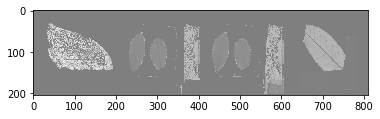

    4    27    27    30


In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = torch.transpose(images, 1, 3)
images = torch.transpose(images, 2, 3)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

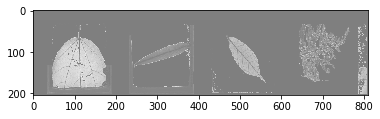

GroundTruth:      9     6    21    24


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images = torch.transpose(images, 1, 3)
images = torch.transpose(images, 2, 3)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Testing

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        #modifications
        #print(images.size())
        images = torch.transpose(images, 1, 3)
        #print(images.size())
        images = torch.transpose(images, 2, 3)
        #print(images.size())
        #labels = torch.tensor([labels])
        
        images = images.type('torch.DoubleTensor')
        images = images.float()
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 99 %


In [21]:
class_correct = list(0. for i in range(38))
class_total = list(0. for i in range(38))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        #modifications
        images = torch.transpose(images, 1, 3)
        images = torch.transpose(images, 2, 3)
        #labels = torch.tensor([labels])
        
        images = images.type('torch.DoubleTensor')
        images = images.float()
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        if(c.size()== torch.Size([4])):
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

for i in range(35):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i] if (class_total[i] != 0) else -1))

Accuracy of     0 : 100 %
Accuracy of     1 : 90 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 100 %
Accuracy of    10 : 100 %
Accuracy of    11 : 100 %
Accuracy of    12 : 100 %
Accuracy of    13 : 100 %
Accuracy of    14 : 100 %
Accuracy of    15 : 100 %
Accuracy of    16 : 100 %
Accuracy of    17 : 100 %
Accuracy of    18 : 100 %
Accuracy of    19 : 100 %
Accuracy of    20 : 100 %
Accuracy of    21 : 100 %
Accuracy of    22 : 100 %
Accuracy of    23 : 100 %
Accuracy of    24 : 100 %
Accuracy of    25 : 100 %
Accuracy of    26 : 100 %
Accuracy of    27 : 100 %
Accuracy of    28 : 100 %
Accuracy of    29 : 100 %
Accuracy of    30 : 100 %
Accuracy of    31 : 100 %
Accuracy of    32 : 100 %
Accuracy of    33 : 100 %
Accuracy of    34 : 100 %


# testing on new images

In [16]:
df_temp = pd.read_csv("C:/Users/Qnouro/Desktop/Programming/Scrapper/leavesDatabase/leaf.csv", 
                  names = ["image array", "type 1", "type2"])

In [17]:
#One Hot Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df_temp.dropna(inplace=True)

data = df_temp['type 1']

values = np.array(data)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
inverted = label_encoder.inverse_transform([32])


c:\users\qnouro\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Manually testing

In [22]:
import random
import cv2

random.seed(20)
random_list = [random.randint(0, len(df.iloc[:, 1:2].values)) for _ in range(20)]


randomizer = []
randomizer_labels = []
for item in random_list:
    try:
        randomizer.append(df["img"][item])
        randomizer_labels.append(df.iloc[1:38].values)
    except:
        input("out of range")
        
random_list_bool = [False for i in range(len(df))]
for index in random_list:
    random_list_bool[index] = True

manual_test = df[random_list_bool]

cleaned_test, _ = splitter(manual_test, manual_test)

        
with torch.no_grad():
    #for index, image in zip(random_list, randomizer):
        ###img reading
        #read_img = cv2.imread(img_path +str(i)+ end_path)
        ##resizing
        #size = (200, 200)
        #fit_and_resized_image = cv2.resize(read_img, dsize=size, interpolation=cv2.INTER_CUBIC)
        #img_array.append(fit_and_resized_image)
        #fit_and_resized_image = 

    for data in cleaned_test:
        image, label = data
        ##prediction
        images = image
        #modifications
        images = torch.transpose(images, 0, 2)
        images = torch.transpose(images, 1, 2)
        images = torch.unsqueeze(images, 0) #adding fake batch
        images = images.type('torch.DoubleTensor')
        images = images.float()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        ##decoding label
        prediction_label = label_encoder.inverse_transform([predicted])[0]
        #expected_label = label_encoder.inverse_transform([list.index(df.iloc[index, 1:36].tolist(), 1)])[0]
        expected_label = label_encoder.inverse_transform([label])[0]

        print(f"expected : {expected_label}")
        print(f"predicted : {prediction_label}\n")

expected : leguminosae 
predicted : leguminosae 

expected : bombacaceae
predicted : bombacaceae

expected : hamamelidaceae
predicted : hamamelidaceae

expected : fagaceae
predicted : fagaceae

expected : phytolaccaceae
predicted : phytolaccaceae

expected : phytolaccaceae
predicted : phytolaccaceae

expected : euphorbiaceae
predicted : euphorbiaceae

expected : monimiaceae 
predicted : monimiaceae 

expected : alangiaceae
predicted : alangiaceae

expected : acanthaceae
predicted : acanthaceae

expected : aceraceae 
predicted : aceraceae 

expected : malvaceae
predicted : malvaceae

expected : menispermaceae
predicted : menispermaceae

expected : araliaceae
predicted : araliaceae

expected : phytolaccaceae
predicted : phytolaccaceae

expected : aceraceae
predicted : aceraceae

expected : menispermaceae
predicted : menispermaceae

expected : acanthaceae
predicted : acanthaceae

expected : hamamelidaceae
predicted : hamamelidaceae

expected : proteaceae
predicted : proteaceae



In [ ]:
torch.all(torch.eq(cleaned_test[0][0], cleaned_test[1][0]))

In [ ]:
len(manual_test)